## Attacking Apples neural hash

This notebook will describe a whitebox attack on the underlying neural network of apples neural hash.

### Loading the model:
Source and Credits: https://github.com/AsuharietYgvar/AppleNeuralHash2ONNX

In [1]:
import sys

import astroid.protocols
import imageio.core
import onnxruntime
import numpy as np
from PIL import Image

In [2]:
MODEL_PATH = "./model.onnx"
OUTPUT_MATRIX_PATH = "./neuralhash_128x96_seed1.dat"

In [3]:
def neural_hash(image):
    # Load ONNX model
    session = onnxruntime.InferenceSession(MODEL_PATH)

    # Load output hash matrix
    seed1 = open(OUTPUT_MATRIX_PATH, 'rb').read()[128:]
    seed1 = np.frombuffer(seed1, dtype=np.float32)
    seed1 = seed1.reshape([96, 128])

    # Preprocess image
    image = Image.open(image).convert('RGB')
    image = image.resize([360, 360])
    arr = np.array(image).astype(np.float32) / 255.0
    arr = arr * 2.0 - 1.0
    arr = arr.transpose(2, 0, 1).reshape([1, 3, 360, 360])

    # Run model
    inputs = {session.get_inputs()[0].name: arr}
    outs = session.run(None, inputs)

    # Convert model output to hex hash
    hash_output = seed1.dot(outs[0].flatten())
    hash_bits = ''.join(['1' if it >= 0 else '0' for it in hash_output])
    hash_hex = '{:0{}x}'.format(int(hash_bits, 2), len(hash_bits) // 4)

    return hash_hex

In [6]:
neural_hash("../shrek.png")

'55d07b72427978ac7a8fd1d9'

### Producing hash collisions
Source and Credits: https://github.com/anishathalye/neural-hash-collider

In [ ]:
# util.py

import numpy as np
import onnx
from onnx_tf.backend import prepare
from PIL import Image


def load_model(path):
    onnx_model = onnx.load(path)
    model = prepare(onnx_model, training_mode=True)
    return model


def load_seed(path):
    seed = open(path, 'rb').read()[128:]
    seed = np.frombuffer(seed, dtype=np.float32)
    seed = seed.reshape([96, 128])
    return seed


def load_image(path):
    im = Image.open(path).convert('RGB')
    im = im.resize([360, 360])
    arr = np.array(im).astype(np.float32) / 255.0
    arr = arr * 2.0 - 1.0
    arr = arr.transpose(2, 0, 1).reshape([1, 3, 360, 360])
    return arr


def save_image(arr, path):
    arr = arr.reshape([3, 360, 360]).transpose(1, 2, 0)
    arr = (arr + 1.0) * (255.0 / 2.0)
    arr = arr.astype(np.uint8)
    im = Image.fromarray(arr)
    im.save(path)


def hash_from_hex(hex_repr):
    n = int(hex_repr, 16)
    h = np.zeros(96)
    for i in range(96):
        h[i] = (n >> (95 - i)) & 1
    return h


def hash_to_hex(h):
    bits = ''.join(['1' if i >= 0.5 else '0' for i in h])
    return '{:0{}x}'.format(int(bits, 2), len(bits) // 4)

In [20]:
# collide.py

import tensorflow as tf
from scipy.ndimage.filters import gaussian_filter
import os


def collide(image1, image2, o_iterations=1000):
    tf.compat.v1.disable_eager_execution()

    model = load_model(MODEL_PATH)
    image = model.tensor_dict['image']
    logits = model.tensor_dict['leaf/logits']
    seed = load_seed(OUTPUT_MATRIX_PATH)

    original = load_image(image1)
    h = hash_from_hex(neural_hash(image2))

    with model.graph.as_default():
        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())

            proj = tf.reshape(tf.linalg.matmul(seed, tf.reshape(logits, (128, 1))), (96,))
            # proj is in R^96; it's interpreted as a 96-bit hash by mapping
            # entries < 0 to the bit '0', and entries >= 0 to the bit '1'
            normalized, _ = tf.linalg.normalize(proj)
            hash_output = tf.sigmoid(normalized * 10.0)
            # now, hash_output has entries in (0, 1); it's interpreted by
            # mapping entries < 0.5 to the bit '0' and entries >= 0.5 to the
            # bit '1'

            # we clip hash_output to (clip_range, 1-clip_range); this seems to
            # improve the search (we don't "waste" perturbation tweaking
            # "strong" bits); the sigmoid already does this to some degree, but
            # this seems to help
            hash_output = tf.clip_by_value(hash_output, 0.1, 0.9) - 0.5
            hash_output = hash_output * (0.5 / 0.4)
            hash_output = hash_output + 0.5

            # hash loss: how far away we are from the target hash
            hash_loss = tf.math.reduce_sum(tf.math.squared_difference(hash_output, h))

            perturbation = image - original
            # image loss: how big / noticeable is the perturbation?
            img_loss = 2e-3 * tf.nn.l2_loss(perturbation) + 1e-4 * tf.image.total_variation(perturbation)[0]

            # combined loss: try to minimize both at once
            combined_loss = 0.8 * hash_loss + 0.2 * img_loss

            # gradients of all the losses
            g_hash_loss, = tf.gradients(hash_loss, image)
            g_img_loss, = tf.gradients(img_loss, image)
            g_combined_loss, = tf.gradients(combined_loss, image)

            # perform attack

            x = original
            best = (float('inf'), 0)  # (distance, image quality loss)
            dist = float('inf')

            for i in range(o_iterations):
                # we do an alternating projections style attack here; if we
                # haven't found a colliding image yet, only optimize for that;
                # if we have a colliding image, then minimize the size of the
                # perturbation; if we're close, then do both at once
                if dist == 0:
                    loss_name, loss, g = 'image', img_loss, g_img_loss
                elif best[0] == 0 and dist <= 2:
                    loss_name, loss, g = 'combined', combined_loss, g_combined_loss
                else:
                    loss_name, loss, g = 'hash', hash_loss, g_hash_loss

                # compute loss values and gradient
                xq = quantize(x)  # take derivatives wrt the quantized version of the image
                hash_output_v, img_loss_v, loss_v, g_v = sess.run([hash_output, img_loss, loss, g], feed_dict={image: xq})
                dist = np.sum((hash_output_v >= 0.5) != (h >= 0.5))

                # if it's better than any image found so far, save it
                score = (dist, img_loss_v)
                if score < best:
                    save_image(x, os.path.join('.', 'out_iter={:05d}_dist={:02d}_q={:.3f}.png'.format(i+1, dist, img_loss_v)))
                    best = score


                # gradient descent step
                g_v_norm = g_v / np.linalg.norm(g_v)
                x = x - 2.0 * g_v_norm
                x = x.clip(-1, 1)
                if (i + 1) % 100 == 0:
                    print('iteration: {}/{}, best: ({}, {:.3f}), hash: {}, distance: {}, loss: {:.3f} ({})'.format(
                        i+1,
                        o_iterations,
                        best[0],
                        best[1],
                        hash_to_hex(hash_output_v),
                        dist,
                        loss_v,
                        loss_name
                    ))

def quantize(x):
    x = (x + 1.0) * (255.0 / 2.0)
    x = x.astype(np.uint8).astype(np.float32)
    x = x / (255.0 / 2.0) - 1.0
    return x


def blur_perturbation(original, x, sigma):
    perturbation = x - original
    perturbation = gaussian_filter_by_channel(perturbation, sigma=sigma)
    return original + perturbation


def gaussian_filter_by_channel(x, sigma):
    return np.stack([gaussian_filter(x[0, ch, :, :], sigma) for ch in range(x.shape[1])])[np.newaxis]

In [21]:
collide("../doge.jpeg", "../titanic.jpeg")

iteration: 100/1000, best: (1, 6.297), hash: 1ec173f89d10be5300ac0206, distance: 1, loss: 6.786 (hash)
iteration: 200/1000, best: (1, 6.297), hash: 1ec173f89d10be5300ac0206, distance: 1, loss: 6.398 (hash)
iteration: 300/1000, best: (1, 6.297), hash: 1ec173f89d10be5300ac0206, distance: 1, loss: 6.329 (hash)
iteration: 400/1000, best: (0, 14.153), hash: 1ec173f89d10be5300ac0206, distance: 1, loss: 6.511 (combined)
iteration: 500/1000, best: (0, 14.153), hash: 1ec173f89d10be5300ac0206, distance: 1, loss: 6.370 (combined)
iteration: 600/1000, best: (0, 14.153), hash: 1ec173f89d10be5300ac0206, distance: 1, loss: 6.340 (combined)
iteration: 700/1000, best: (0, 14.153), hash: 1ec173f89d10be5300ac0206, distance: 1, loss: 6.317 (combined)
iteration: 800/1000, best: (0, 14.153), hash: 1ec173f89d10be5300ac0206, distance: 1, loss: 6.290 (combined)
iteration: 900/1000, best: (0, 14.153), hash: 1ec173f89d10be5300ac0206, distance: 1, loss: 6.280 (combined)
iteration: 1000/1000, best: (0, 14.153), ha

## Task 1:

Investigating how much **information leak** through neural-hashing

In [4]:
# imports
from openimages.download import download_images
import os

In [2]:
# Load dataset(s)

download_images("../datasets", ["Person", "Wheel", "Human hair",
                                "Flower", "Window", "House",
                                "Table", "Glasses", "Tree",
                                "Man", "Plant", "Footwear",
                                "Woman", "Girl", "Boy", "Clothing",
                                "Building", "Car", "Dress"],
                "../exclusion", limit=500)

KeyboardInterrupt: 

In [17]:
# Hash dataset

base = "../datasets/"
ext = "/images/"
labels = os.listdir(base)

with open("hashes.txt", "w") as fd:
    print(f"classifiers: {labels}")
    for label in labels:
        files = os.listdir(base + label + ext)
        print(f"hashing {len(files)} images [{label}]")
        for file in files:
            fd.write(neural_hash(base + label + ext + file) + ", " + label + "\n")


classifiers: ['man', 'tree', 'car', 'footwear', 'boy', 'plant', 'person', 'flower', 'clothing', 'dress', 'wheel', 'glasses', 'table', 'window', 'girl', 'house', 'human hair', 'woman', 'building']
hashing 500 images [man]
hashing 500 images [tree]
hashing 500 images [car]
hashing 500 images [footwear]
hashing 500 images [boy]
hashing 500 images [plant]
hashing 500 images [person]
hashing 500 images [flower]
hashing 500 images [clothing]
hashing 500 images [dress]
hashing 500 images [wheel]
hashing 500 images [glasses]
hashing 500 images [table]
hashing 500 images [window]
hashing 500 images [girl]
hashing 500 images [house]
hashing 500 images [human hair]
hashing 500 images [woman]
hashing 500 images [building]


In [ ]:
# Define new model to classify hashes

In [ ]:
# Train model

In [ ]:
# Evaluate accuracy

In [ ]:
# Visualize results

## Task 2:

Detection Evasion using simple image altering

In [2]:
from fimage import FImage
from fimage.filters import Sepia, Contrast, Brightness, Vibrance
import progressbar
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
# Define image manipulation functions
# Functions get file_name as str and output a new file_name as str
working_image_path = "filter_applied.jpeg"

def function1(image_path, **kwargs):
    # Apply Sepia filter
    image = FImage(image_path)

    strength = kwargs.get("strength", 80)

    image.apply(Sepia(strength))

    image.save(working_image_path)
    return working_image_path

def function2(image_path, **kwargs):
    image = FImage(image_path)

    strength = kwargs.get("strength", 20)

    image.apply(Contrast(strength))

    image.save(working_image_path)
    return working_image_path

# Multiple filters
def function3(image_path, **kwargs):
    image = FImage(image_path)

    strength = kwargs.get("strength", 10)

    image.apply(Contrast(strength))
    image.apply(Brightness(strength))
    image.apply(Vibrance(strength))

    image.save(working_image_path)
    return working_image_path

In [7]:
# Load dataset
filter_datasets = ["Person", "House", "Boy"]
num_images = 500

# Check if we need to download sets
filter_datasets_to_download = []
for directory in filter_datasets:
    path = f"../datasets/{directory.lower()}/images"
    print(path)
    ls = os.listdir(path)
    if (len(ls) < num_images):
        filter_datasets_to_download.append(directory)

if len(filter_datasets_to_download) > 0:
    print(f"Downloading {len(filter_datasets_to_download)} datasets")
    download_images("../datasets", filter_datasets_to_download, "../exclusion", limit=num_images)

../datasets/person/images
../datasets/house/images
../datasets/boy/images


In [8]:
# Transform datasets using manipulation functions

In [9]:
# Perform neural hash on transformed and non-transformed
# dataset, then evaluate amount of changed bits in hash

# calculate the bitwise difference between two neural hashes
def difference(hash1: str, hash2: str):
    one = format(int(hash1, 16), "#098b")[2:]
    two = format(int(hash2, 16), "#098b")[2:]
    return sum([one[i] != two[i] for i in range(96)])

# evaluate difference in hashes w & w/o filter on
def filter_difference(image, function, **kwargs):
    return difference(
        neural_hash(image),
        neural_hash(function(image, **kwargs))
    )


def evaluate_filter(datasets, function, **kwargs):
    base = "../datasets/"
    ext = "/images/"
    filter_differences = []
    for dataset in datasets:
        dataset_diff_sum = 0
        path = (base + dataset + ext).lower()
        files = os.listdir(path)
        print(f"Evaluating {len(files)} images of {dataset} with {function.__name__} and {kwargs}")
        sys.stdout.flush() # flush output to prevent weird behavior with progressbar in jupyter
        for i in progressbar.progressbar(range(len(files))):
            diff = filter_difference(path + files[i], function, **kwargs)
            dataset_diff_sum += diff
        dataset_diff_avg = dataset_diff_sum / len(files)
        filter_differences.append(dataset_diff_avg)
        print(f"Result: average hash difference of {dataset_diff_avg}")
        print("-"*50)

    filter_avg = sum(filter_differences) / len(filter_differences)
    print(f"Average hash difference of {function.__name__} and {kwargs}: {filter_avg}")
    print()
    print("#"*50)
    print()

def visualize_filter(function, function_name, strengths):
    amount = len(strengths) + 1
    fig, ax = plt.subplots(1, amount, figsize=(amount * 5, 5))
    i = 0
    ax[i].imshow(mpimg.imread("../doge.jpeg"))
    ax[i].set_title("Original")
    for strength in strengths:
        i += 1
        ax[i].imshow(mpimg.imread(function("../doge.jpeg", strength=strength)))
        ax[i].set_title(f"{function_name} with strength {strength}")


Evaluating 500 images of Person with function1 and {'strength': 50}


100% (500 of 500) |######################| Elapsed Time: 0:01:31 Time:  0:01:31


Result: average hash difference of 4.914
--------------------------------------------------
Evaluating 500 images of House with function1 and {'strength': 50}


100% (500 of 500) |######################| Elapsed Time: 0:01:30 Time:  0:01:30


Result: average hash difference of 5.352
--------------------------------------------------
Evaluating 500 images of Boy with function1 and {'strength': 50}


100% (500 of 500) |######################| Elapsed Time: 0:01:30 Time:  0:01:30


Result: average hash difference of 4.588
--------------------------------------------------
Average hash difference of function1 and {'strength': 50}: 4.951333333333333

##################################################

Evaluating 500 images of Person with function1 and {'strength': 80}


100% (500 of 500) |######################| Elapsed Time: 0:01:30 Time:  0:01:30


Result: average hash difference of 9.662
--------------------------------------------------
Evaluating 500 images of House with function1 and {'strength': 80}


100% (500 of 500) |######################| Elapsed Time: 0:01:30 Time:  0:01:30


Result: average hash difference of 10.342
--------------------------------------------------
Evaluating 500 images of Boy with function1 and {'strength': 80}


100% (500 of 500) |######################| Elapsed Time: 0:01:30 Time:  0:01:30


Result: average hash difference of 9.608
--------------------------------------------------
Average hash difference of function1 and {'strength': 80}: 9.870666666666667

##################################################

Evaluating 500 images of Person with function1 and {'strength': 100}


100% (500 of 500) |######################| Elapsed Time: 0:01:30 Time:  0:01:30


Result: average hash difference of 13.512
--------------------------------------------------
Evaluating 500 images of House with function1 and {'strength': 100}


100% (500 of 500) |######################| Elapsed Time: 0:01:29 Time:  0:01:29


Result: average hash difference of 14.058
--------------------------------------------------
Evaluating 500 images of Boy with function1 and {'strength': 100}


100% (500 of 500) |######################| Elapsed Time: 0:01:28 Time:  0:01:28


Result: average hash difference of 13.556
--------------------------------------------------
Average hash difference of function1 and {'strength': 100}: 13.708666666666666

##################################################



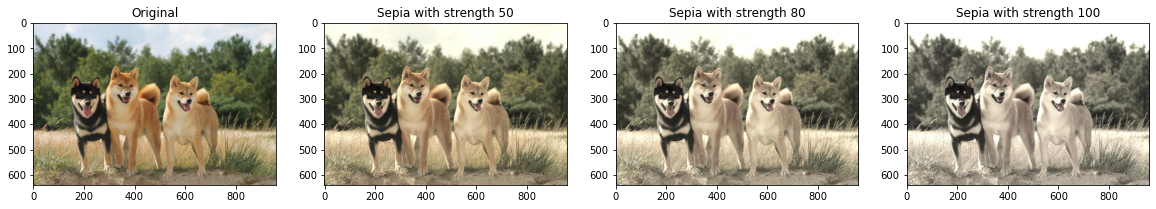

In [10]:
# Sepia
sepia_strengths = [50, 80, 100]
visualize_filter(function1, "Sepia", sepia_strengths)
for strength in sepia_strengths:
    evaluate_filter(filter_datasets, function1, strength=strength)


Evaluating 500 images of Person with function2 and {'strength': 10}


100% (500 of 500) |######################| Elapsed Time: 0:01:27 Time:  0:01:27


Result: average hash difference of 6.618
--------------------------------------------------
Evaluating 500 images of House with function2 and {'strength': 10}


100% (500 of 500) |######################| Elapsed Time: 0:01:26 Time:  0:01:26


Result: average hash difference of 5.754
--------------------------------------------------
Evaluating 500 images of Boy with function2 and {'strength': 10}


100% (500 of 500) |######################| Elapsed Time: 0:01:26 Time:  0:01:26


Result: average hash difference of 6.298
--------------------------------------------------
Average hash difference of function2 and {'strength': 10}: 6.223333333333334

##################################################

Evaluating 500 images of Person with function2 and {'strength': 20}


100% (500 of 500) |######################| Elapsed Time: 0:01:26 Time:  0:01:26


Result: average hash difference of 13.726
--------------------------------------------------
Evaluating 500 images of House with function2 and {'strength': 20}


100% (500 of 500) |######################| Elapsed Time: 0:01:27 Time:  0:01:27


Result: average hash difference of 12.98
--------------------------------------------------
Evaluating 500 images of Boy with function2 and {'strength': 20}


100% (500 of 500) |######################| Elapsed Time: 0:01:26 Time:  0:01:26


Result: average hash difference of 13.682
--------------------------------------------------
Average hash difference of function2 and {'strength': 20}: 13.462666666666669

##################################################

Evaluating 500 images of Person with function2 and {'strength': 30}


100% (500 of 500) |######################| Elapsed Time: 0:01:26 Time:  0:01:26


Result: average hash difference of 19.502
--------------------------------------------------
Evaluating 500 images of House with function2 and {'strength': 30}


100% (500 of 500) |######################| Elapsed Time: 0:01:26 Time:  0:01:26


Result: average hash difference of 18.538
--------------------------------------------------
Evaluating 500 images of Boy with function2 and {'strength': 30}


100% (500 of 500) |######################| Elapsed Time: 0:01:26 Time:  0:01:26


Result: average hash difference of 19.646
--------------------------------------------------
Average hash difference of function2 and {'strength': 30}: 19.228666666666665

##################################################



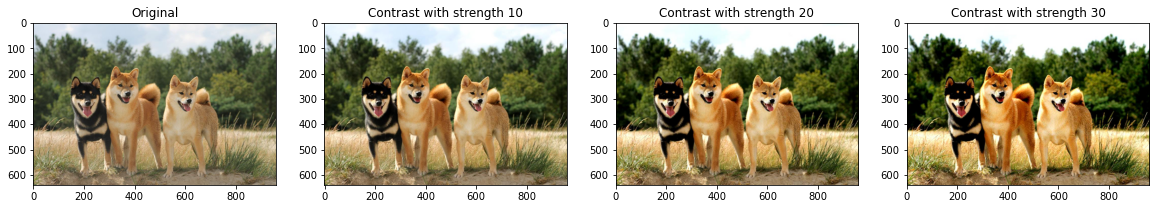

In [11]:
# Contrast
contrast_strengths = [10, 20, 30]
visualize_filter(function2, "Contrast", strengths=contrast_strengths)
for strength in contrast_strengths:
    evaluate_filter(filter_datasets, function2, strength=strength)


Evaluating 500 images of Person with function3 and {'strength': 5}


100% (500 of 500) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Result: average hash difference of 4.324
--------------------------------------------------
Evaluating 500 images of House with function3 and {'strength': 5}


100% (500 of 500) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Result: average hash difference of 3.974
--------------------------------------------------
Evaluating 500 images of Boy with function3 and {'strength': 5}


100% (500 of 500) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Result: average hash difference of 4.122
--------------------------------------------------
Average hash difference of function3 and {'strength': 5}: 4.14

##################################################

Evaluating 500 images of Person with function3 and {'strength': 10}


100% (500 of 500) |######################| Elapsed Time: 0:02:00 Time:  0:02:00


Result: average hash difference of 9.95
--------------------------------------------------
Evaluating 500 images of House with function3 and {'strength': 10}


100% (500 of 500) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Result: average hash difference of 9.314
--------------------------------------------------
Evaluating 500 images of Boy with function3 and {'strength': 10}


100% (500 of 500) |######################| Elapsed Time: 0:01:59 Time:  0:01:59


Result: average hash difference of 9.472
--------------------------------------------------
Average hash difference of function3 and {'strength': 10}: 9.578666666666665

##################################################

Evaluating 500 images of Person with function3 and {'strength': 20}


100% (500 of 500) |######################| Elapsed Time: 0:01:59 Time:  0:01:59


Result: average hash difference of 19.964
--------------------------------------------------
Evaluating 500 images of House with function3 and {'strength': 20}


100% (500 of 500) |######################| Elapsed Time: 0:01:58 Time:  0:01:58


Result: average hash difference of 19.268
--------------------------------------------------
Evaluating 500 images of Boy with function3 and {'strength': 20}


100% (500 of 500) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Result: average hash difference of 20.576
--------------------------------------------------
Average hash difference of function3 and {'strength': 20}: 19.936

##################################################

Evaluating 500 images of Person with function3 and {'strength': 30}


100% (500 of 500) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Result: average hash difference of 27.102
--------------------------------------------------
Evaluating 500 images of House with function3 and {'strength': 30}


100% (500 of 500) |######################| Elapsed Time: 0:02:00 Time:  0:02:00


Result: average hash difference of 26.282
--------------------------------------------------
Evaluating 500 images of Boy with function3 and {'strength': 30}


100% (500 of 500) |######################| Elapsed Time: 0:02:00 Time:  0:02:00


Result: average hash difference of 27.786
--------------------------------------------------
Average hash difference of function3 and {'strength': 30}: 27.05666666666667

##################################################

Evaluating 500 images of Person with function3 and {'strength': 50}


100% (500 of 500) |######################| Elapsed Time: 0:02:01 Time:  0:02:01


Result: average hash difference of 34.518
--------------------------------------------------
Evaluating 500 images of House with function3 and {'strength': 50}


100% (500 of 500) |######################| Elapsed Time: 0:01:58 Time:  0:01:58


Result: average hash difference of 33.33
--------------------------------------------------
Evaluating 500 images of Boy with function3 and {'strength': 50}


100% (500 of 500) |######################| Elapsed Time: 0:02:00 Time:  0:02:00


Result: average hash difference of 35.4
--------------------------------------------------
Average hash difference of function3 and {'strength': 50}: 34.416

##################################################



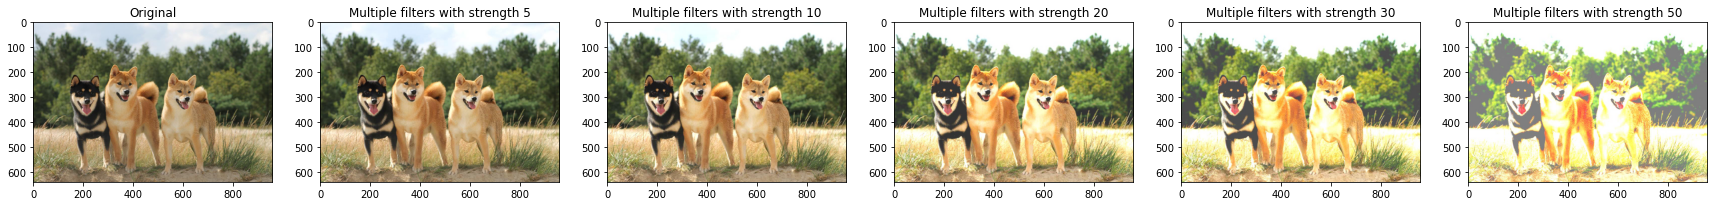

In [13]:
# Multiple filters
multiple_strengths = [5, 10, 20, 30, 50]
visualize_filter(function3, "Multiple filters", strengths=multiple_strengths)
for strength in multiple_strengths:
    evaluate_filter(filter_datasets, function3, strength=strength)

# Visualize Results
Non-dynamic Data Visualization by Hand

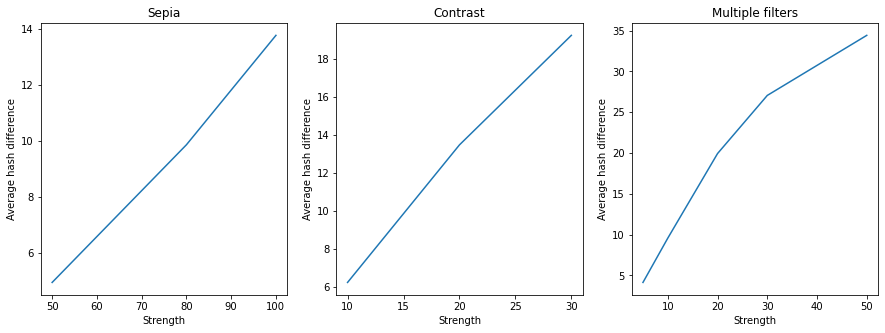

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

#Don't want to rerun the filters, therefore copying the variables
sepia_strengths = [50, 80, 100]
contrast_strengths = [10, 20, 30]
multiple_strengths = [5, 10, 20, 30, 50]


sepia_differences = [4.9513, 9.8706, 13.7806]
contrast_differences = [6.223, 13.4626, 19.2286]
multiple_differences = [4.14, 9.5786, 19.936,  27.056, 34.416]

ax[0].plot(sepia_strengths, sepia_differences)
ax[0].set_title("Sepia")

ax[1].plot(contrast_strengths, contrast_differences)
ax[1].set_title("Contrast")

ax[2].plot(multiple_strengths, multiple_differences)
ax[2].set_title("Multiple filters")

for i in range(3):
    ax[i].set_xlabel("Strength")
    ax[i].set_ylabel("Average hash difference")

plt.show()